# Imports and Custom Functions

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle

In [2]:
def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

In [3]:
def closest(lst, k):
    
    number = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-k))]
      
    return number 

In [4]:
def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

In [5]:
# unipartite positive and negative layers ...k01, k10 are column vectors
def multidegree_entropy_pos_neg(k01, k10, precision=10**(-5), loops=10000):
    n=len(k01)
    t01=np.random.uniform(size=(n,1))
    t10=np.random.uniform(size=(n,1))
    oldt01=np.random.uniform(size=(n,1))
    oldt10=np.random.uniform(size=(n,1))    
    
    for kk in tqdm(range(loops)):
            T01=t01*(t01.transpose())
            T10=t10*(t10.transpose())
            Z=1+ T01 + T10
            
            #p01
            summat=(np.ones((n,1))*t01.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1, keepdims=True);
            t01=k01/(summat+(summat==0))
            T01=t01*(t01.transpose())
            
            Z=1+ T01 + T10
    
            #p10
            summat=(np.ones((n,1))*t10.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1,keepdims=True)
            t10=k10/(summat+(summat==0))
            
            #print((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))))
            
            #print(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0))))))
            
            if np.logical_and((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))< precision),(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))<precision)):
                break

            oldt01=t01
            oldt10=t10
            
            
    print("Loops ", kk+1)
    print('Error margin: ', max((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))),max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))))
    T01=t01*(t01.transpose());
    T10=t10*(t10.transpose());

    Z=1+ T01 + T10;
    
    
    summat01=T01/(Z+(Z==0))
    summat01=summat01-np.diag(np.diagonal(summat01))
    k01cal=np.sum(summat01,axis=1,keepdims=True);  
    
    summat10=T10/(Z+(Z==0))
    summat10=summat10-np.diag(np.diagonal(summat10))
    k10cal=np.sum(summat10,axis=1,keepdims=True)
                    
    pconditional=summat10/(summat10+summat01+(summat10==0))
    
    return (summat01, k01cal, summat10, k10cal, pconditional)   

In [6]:
def generate_network(G, node_Kd_values, kd_list, p_bind = 0.5):
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(node_Kd_values[edge[0]])
        node_Kd_list_2.append(node_Kd_values[edge[1]])
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
    
    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data


In [7]:
def run_configuration_model(network_data, precision=10**(-5), loops=10000):

    ## Create train-test split

    train, test = train_test_split(network_data, test_size=0.3)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    ## Degree ratio distirbution

    degree_ratio_list = [degree_train_1_0[i]/(degree_train_1_0[i] + degree_train_0_1[i]) for i in range(len(train_nodes))]

    figure(figsize=(8, 8))
    ax = sns.distplot(degree_ratio_list, norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel=r'$\rho$', ylabel='PDF')
    plt.show()

    sum_degree =  [a + b for a,b in zip(degree_train_1_0,degree_train_0_1)]
    print('Number of nodes with not positive or negative annotation: ', sum_degree.count(0))

    print('Validating p_bind value from binary labels: ', network_data['binary_label'].tolist().count(1) / len(network_data))

    summat01, k01cal, summat10, k10cal, pconditional = multidegree_entropy_pos_neg(np.array([degree_train_0_1]).T, np.array([degree_train_1_0]).T, precision=precision, loops=loops)

    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    p10_avg = np.mean(summat10)
    p01_avg = np.mean(summat01)
    average_conditional_probability = p10_avg / (p10_avg + p01_avg)

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2]
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        else:
            p10_conditioned = average_conditional_probability
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    ## Performance on the test dataset

    print('AUC: ', roc_auc_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))

    print('Transductive performance:')

    test_predictions_transductive = test_predictions[test_predictions['test_type'] == 'Transductive']
    print('AUC: ', roc_auc_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))

    figure(figsize=(8, 8))
    ax = sns.distplot(test_predictions['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel='$p^{conditional}$', ylabel='PDF')
    plt.show()
    
    return

# Analysis of BindingDB Kd (DeepPurpose)

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70750 drug target pairs.


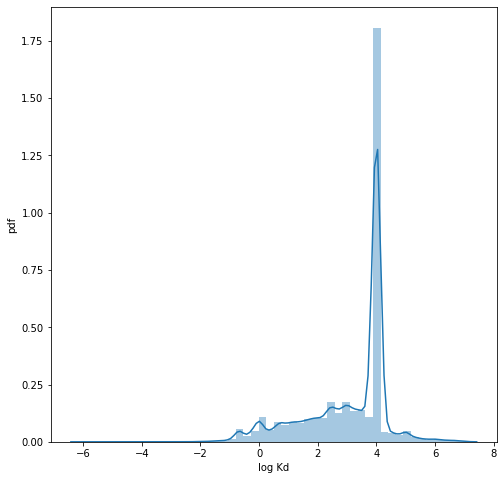

In [8]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)

df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[df_want.Label <= 10000000.0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

kd_list = list(df_want.Label.values)

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')
plt.show()

# Constructing the BindingDB DTI

In [9]:
df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

threshold = 30 ## DeepPurpose threshold in nM

df_want_Kd_binary = df_want_Kd.copy()
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

100%|██████████| 70750/70750 [00:00<00:00, 1612457.52it/s]


In [10]:
target_annotations_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))

100%|██████████| 1507/1507 [00:13<00:00, 109.16it/s]


In [11]:
print('Average annotations for proteins: ', np.mean(target_annotations_bindingDB))
print('Protein degree distribution - Power Law')
results = powerlaw.Fit(target_annotations_bindingDB)
gamma_p = results.power_law.alpha
print('Gamma_p: ', gamma_p)

Average annotations for proteins:  46.94757796947578
Protein degree distribution - Power Law
Calculating best minimal value for power law fit
Gamma_p:  2.844854527120699


# Protein Annotaion and Kd

In [12]:
print('Number of proteins/nodes: ', len(targets))

Number of proteins/nodes:  1507


In [13]:
target_annotations = []
target_average_Kd = []

for prot in tqdm(targets):
    sub_df = df_want_Kd[df_want_Kd['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df['Label'].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    
print('Proteins - Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))

100%|██████████| 172/172 [00:00<00:00, 6176.76it/s]

Proteins - Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.4673048395959652, pvalue=1.0298775028113185e-10)


Mean and standard deviation of log Kd:  7.104377155054556 3.333661394378017


Text(0, 0.5, 'Average $K_d$')

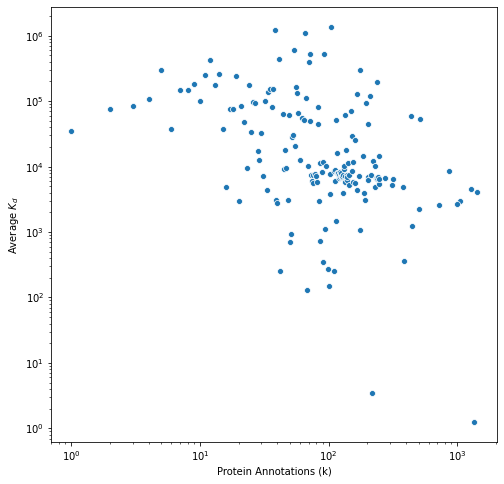

In [14]:
mean_log_Kd = np.mean(np.log(remove_zeros_distribution(kd_list)))
std_log_Kd = np.std(np.log(remove_zeros_distribution(kd_list)))

print('Mean and standard deviation of log Kd: ', mean_log_Kd, std_log_Kd)

figure(figsize=(8, 8))
sns.scatterplot(different_target_annotations,unique_Kd_targets)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Protein Annotations (k)')
plt.ylabel(r'Average $K_d$')

In [15]:
print('Average degree of proteins: ', np.mean(target_annotations))

Average degree of proteins:  46.94757796947578


# Power-Law + Correlation

## Generating Gaussian Copula

kmin:  1
kmax:  4999
Max CDF for inverse sampling degree:  0.9999999852148597
Max CDF for inverse sampling Kd:  0.9997854118275897
Calculating best minimal value for power law fit
Gamma_p:  2.844854527120699
Max inverse sampled degree:  4998.999974019441
Max Kd samples from copula:  152661651.85033053


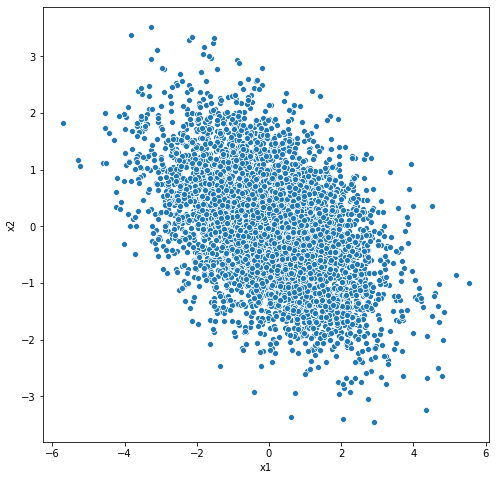

In [16]:
mean = [0, 0]
sigmax = 1.5 ## Taking larger sigmas into account to accomodate extreme values from power-law
sigmay =  1.0
anti_corr = -0.47
cov = [[sigmax**2, anti_corr*sigmax*sigmay], [anti_corr*sigmax**sigmay, sigmay**2]] # COVARIANCE matrix

simulated_network_nodes =  5000 ## len(target_annotations) ## Original network has 1,507 
x1, x2 = np.random.multivariate_normal(mean, cov, size=simulated_network_nodes).T

figure(figsize=(8, 8))
sns.scatterplot(x1,x2)
plt.xlabel('x1')
plt.ylabel('x2')

## Cumulative distributions

U1 = norm.cdf(x1)
U2 = norm.cdf(x2)

Kmin = 1 ## min(target_annotations)
print('kmin: ', Kmin)
Kmax = simulated_network_nodes - 1 ## max(target_annotations)
print('kmax: ', Kmax)

print('Max CDF for inverse sampling degree: ', max(U1))
print('Max CDF for inverse sampling Kd: ', max(U2))

results_sampled = powerlaw.Fit(target_annotations_bindingDB)
gamma_p = results.power_law.alpha
print('Gamma_p: ', gamma_p)

print('Max inverse sampled degree: ', (max(U1) * (Kmax**gamma_p - Kmin**gamma_p) + Kmin**gamma_p) ** (1/gamma_p))

print('Max Kd samples from copula: ', np.exp(norm.ppf(max(U2), loc=mean_log_Kd, scale=std_log_Kd)))

## Sampling Degree Values from Power-Law

100%|██████████| 116/116 [00:00<00:00, 2223.79it/s]


Calculating best minimal value for power law fit
Gamma sampled from copula:  1.987800213486571
7.040426408507629
7.104377155054556
3.286170627770408
3.333661394378017
Correlation between k and Kd obtained from copula:  SpearmanrResult(correlation=-0.38560139761350976, pvalue=5.716454947352684e-177)
False
True
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.5555683696613232, pvalue=9.601472778006109e-11)


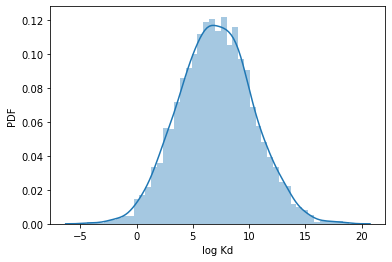

In [17]:
gamma = gamma_p

K_from_copula_list = [1] ## Initialization
   
K_from_copula_list = []
Kd_from_copula_list = []
    
for j in tqdm(range(len(U1))):
    exponent = -gamma + 1
    k_value = (U1[j] * (Kmax**exponent - Kmin**exponent) + Kmin**exponent) ** (1/exponent) ## Inverse CDF of power-law
    K_from_copula_list.append(int(k_value))
    Kd_from_copula_list.append(np.exp(norm.ppf(U2[j], loc=mean_log_Kd, scale=std_log_Kd))) ## Inverse log-normal

results_sampled = powerlaw.Fit(K_from_copula_list)
gamma_sampled = results_sampled.power_law.alpha
print('Gamma sampled from copula: ', gamma_sampled)

sns.distplot(np.log(Kd_from_copula_list))
plt.xlabel('log Kd')
plt.ylabel('PDF')

## Checks on original Kd duistribution and Kd from copula

print(np.mean(np.log(Kd_from_copula_list)))
print(mean_log_Kd)
print(np.std(np.log(Kd_from_copula_list)))
print(std_log_Kd)

## Correlation between k and Kd obtained from copula 

print('Correlation between k and Kd obtained from copula: ', stats.spearmanr(K_from_copula_list,Kd_from_copula_list))

print(sum(K_from_copula_list) % 2 == 0) ## True if graphical

## Making the degree sequence graphical

if (sum(K_from_copula_list) % 2 == 0) is False:
    non_1_degrees = []
    for x in K_from_copula_list:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_list.index(random_non_1_entry)
    K_from_copula_list[j] = K_from_copula_list[j] - 1
    print(sum(K_from_copula_list) % 2 == 0)
else:
    print(sum(K_from_copula_list) % 2 == 0) 
    
## Check correlation between k and Kd
    
different_target_annotations_copula = list(set(K_from_copula_list))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(Kd_from_copula_list[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))


## Validating the generated data from Copula

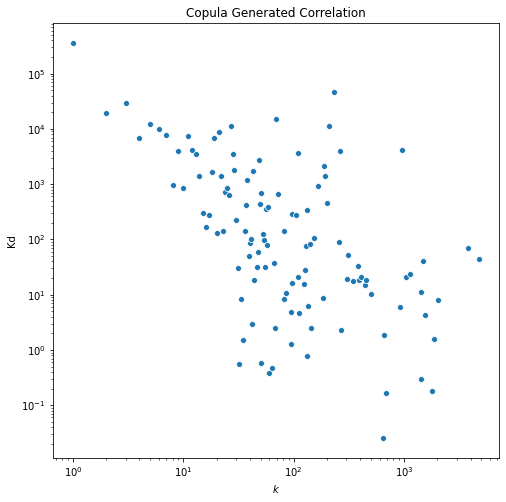

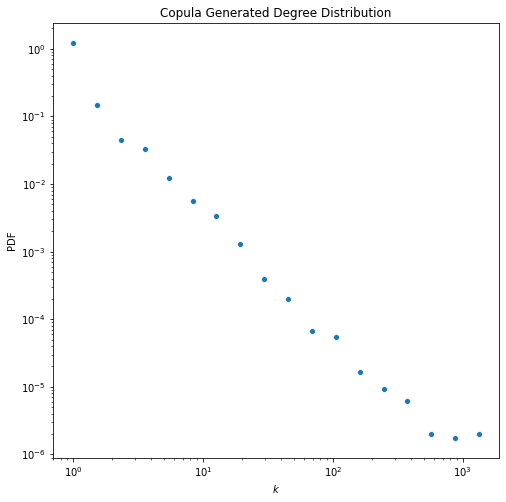

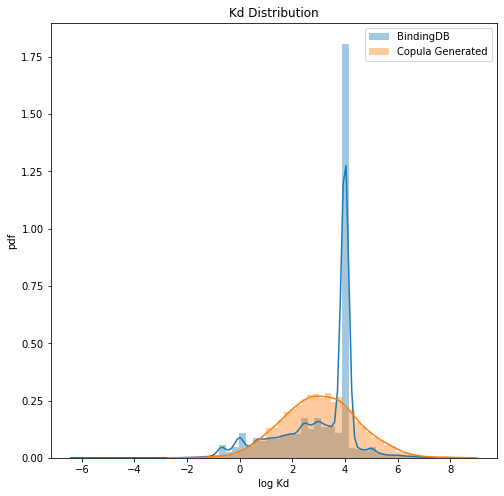

In [18]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(K_from_copula_list,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(Kd_from_copula_list), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

## Generating Network

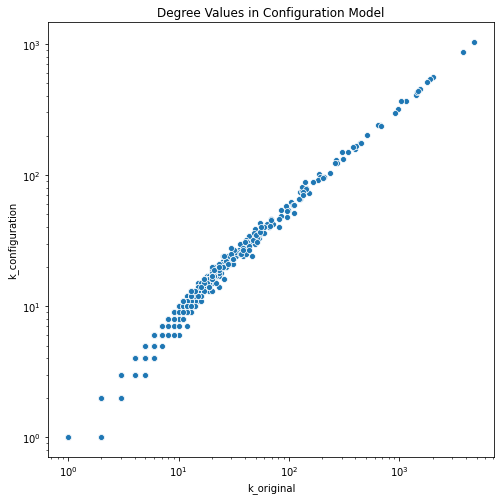

Correlation between k and Kd:  SpearmanrResult(correlation=-0.3847843889410014, pvalue=3.632119718365548e-176)
Max degree in degree sequence:  4750
Max degree in network:  1033
Mean degree in degree sequence:  9.9228
Mean degree in network:  4.9348
Calculating best minimal value for power law fit
Gamma in generated network:  2.166156379822282
Expected Max degree in network:  1485.7067133249088


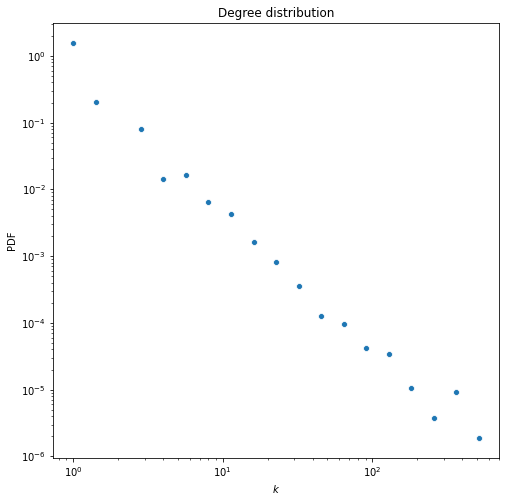

In [19]:
node_Kd_values = dict(zip(range(len(K_from_copula_list)), Kd_from_copula_list)) ## Nodes are numbered 0, 1,..., N
G = nx.configuration_model(K_from_copula_list, create_using=nx.Graph(), seed=None)

## Checks after removing self-loops and multi-edges

degrees_from_network = [G.degree(node) for node in list(G.nodes())]
figure(figsize=(8, 8))
ax = sns.scatterplot(K_from_copula_list, degrees_from_network)
ax.set(title='Degree Values in Configuration Model',xscale='log',yscale='log',xlabel='k_original',ylabel='k_configuration')
plt.show()

print('Correlation between k and Kd: ', stats.spearmanr(degrees_from_network, Kd_from_copula_list))

print('Max degree in degree sequence: ', max(K_from_copula_list))
print('Max degree in network: ', max(degrees_from_network))

print('Mean degree in degree sequence: ', np.mean(K_from_copula_list))
print('Mean degree in network: ', np.mean(degrees_from_network))

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_network,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Degree distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

r=powerlaw.Fit(degrees_from_network)
print('Gamma in generated network: ', r.power_law.alpha)

print('Expected Max degree in network: ', min(degrees_from_network) * simulated_network_nodes**(1/(r.power_law.alpha-1)))

## Run Configuration Model

100%|██████████| 12337/12337 [00:00<00:00, 618827.63it/s]


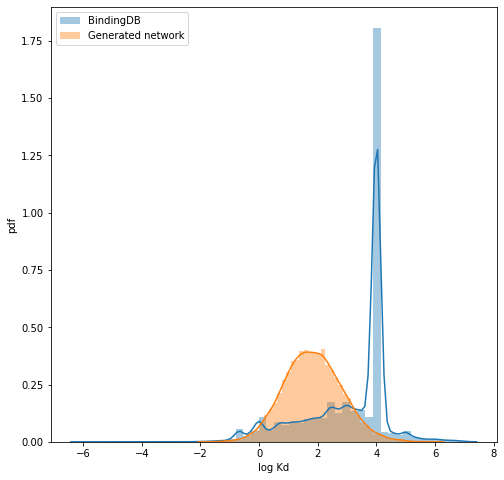

Threshold:  69.17241878478146


In [20]:
network_data = generate_network(G, node_Kd_values, kd_list, p_bind = 0.5)

100%|██████████| 3951/3951 [00:09<00:00, 431.73it/s]


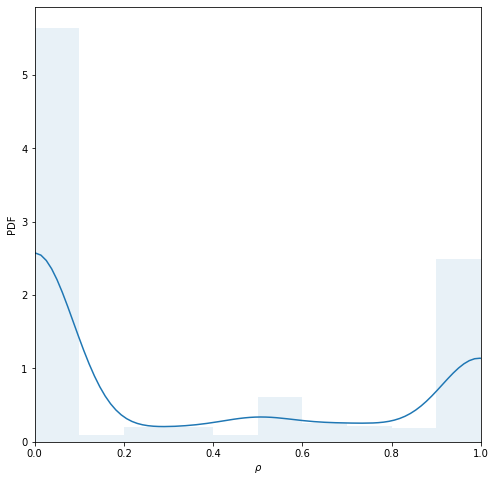

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.5096052524925022


  1%|          | 58/10000 [00:41<1:58:25,  1.40it/s]


Loops  59
Error margin:  [8.38588499e-06]


3702it [00:09, 380.98it/s]


AUC:  0.8316638536203614
AUP:  0.7926012443816837
Transductive performance:
AUC:  0.8493874009030873
AUP:  0.8419045995508383


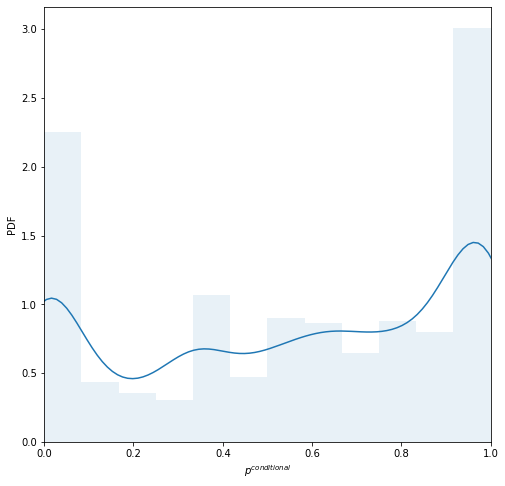

In [21]:
run_configuration_model(network_data)

# Power-Law + No Correlation

## Shuffle Kd

In [22]:
correlated_labels = network_data['edge_Kd'] 
shuffle(correlated_labels)
network_data['edge_Kd'] = correlated_labels

/miniconda/lib/python3.6/random.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]


## Generate Network and Run Configuration Model

In [23]:
p_bind = 0.5
Kd_for_edges = network_data['edge_Kd'].tolist()
threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
print('Threshold: ', threshold) ## in nM

binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

network_data['binary_label'] = binary_labels

Threshold:  69.17241878478146


100%|██████████| 3963/3963 [00:09<00:00, 423.82it/s]


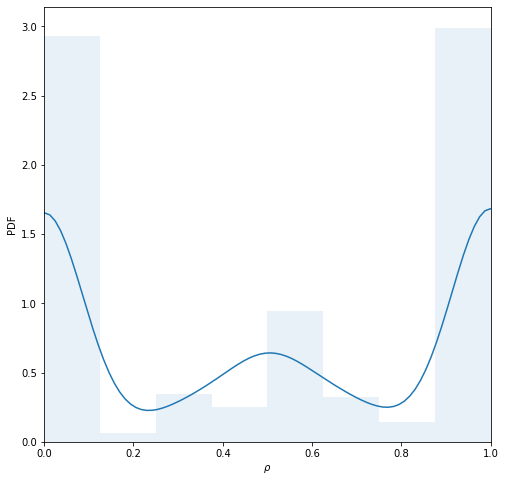

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.5096052524925022


  1%|          | 53/10000 [00:38<2:00:23,  1.38it/s]


Loops  54
Error margin:  [9.57118233e-06]


3702it [00:09, 375.15it/s]


AUC:  0.4940658444990089
AUP:  0.5114612181984631
Transductive performance:
AUC:  0.49198055188099055
AUP:  0.5126492619275976


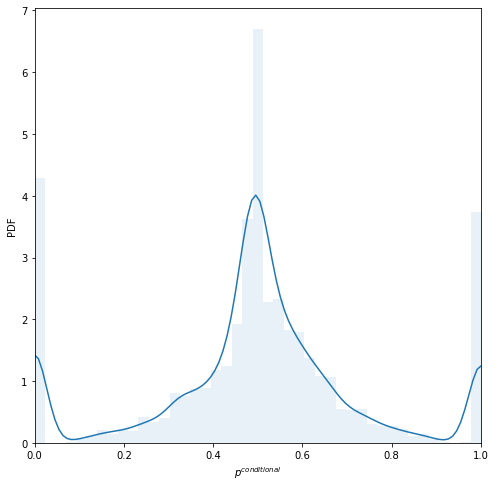

In [24]:
run_configuration_model(network_data)

## Check: k and Kd correlation after shuffling

100%|██████████| 94/94 [00:00<00:00, 2178.27it/s]

Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=0.33932426112793806, pvalue=5.74915093724493e-135)
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.012433623523462053, pvalue=0.9053228111340592)


[None,
 Text(0, 0.5, 'Kd'),
 None,
 Text(0.5, 0, '$k$'),
 Text(0.5, 1.0, 'Shuffled Kd')]

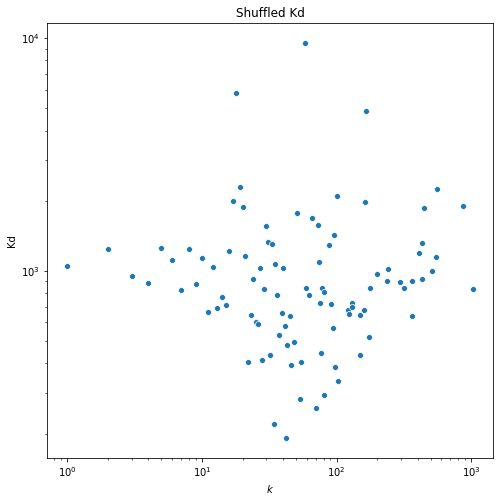

In [25]:
all_degree_list = []
all_avg_Kd_list = []

for node in tqdm(range(simulated_network_nodes)):
    sub_df = network_data[(network_data['node_1']==node) | (network_data['node_2']==node)]
    all_degree_list.append(len(sub_df))
    all_avg_Kd_list.append(np.mean(sub_df['edge_Kd'].tolist()))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(all_degree_list,all_avg_Kd_list))

different_target_annotations_copula = list(set(all_degree_list))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(all_degree_list,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(all_avg_Kd_list[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Shuffled Kd',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

# Poisson + Correlation

## Generating Gaussian Copula

  4%|▍         | 188/5000 [00:00<00:02, 1875.18it/s]

Degree density:  4.9348


100%|██████████| 5000/5000 [00:01<00:00, 2593.10it/s]


Mean and variance of sampled Poisson:  4.942 4.911436


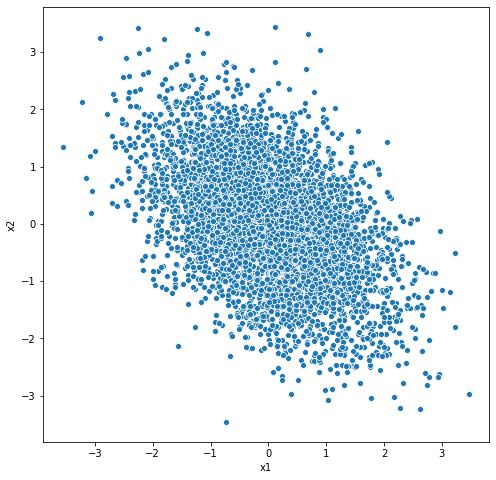

In [26]:
mean = [0, 0]
sigmax = 1.0 ## Taking smaller sigma range for Poisson
sigmay =  1.0
anti_corr = -0.47
cov = [[sigmax**2, anti_corr*sigmax*sigmay], [anti_corr*sigmax**sigmay, sigmay**2]] # COVARIANCE matrix

x1, x2 = np.random.multivariate_normal(mean, cov, size=simulated_network_nodes).T

figure(figsize=(8, 8))
sns.scatterplot(x1,x2)
plt.xlabel('x1')
plt.ylabel('x2')

## Cumulative distributions

U1 = norm.cdf(x1)
U2 = norm.cdf(x2)

Kavg = np.mean(degrees_from_network) 
print('Degree density: ', Kavg)

K_from_copula_list = [1] ## Initialization
    
K_from_copula_list = []
Kd_from_copula_list = []
    
for j in tqdm(range(len(U1))):
    k_value = poisson.ppf(U1[j], Kavg, loc=0) ## Inverse CDF of Poisson
    if int(k_value) == 0:
        K_from_copula_list.append(1)
    else:
        K_from_copula_list.append(int(k_value))
    Kd_from_copula_list.append(np.exp(norm.ppf(U2[j], loc=mean_log_Kd, scale=std_log_Kd))) ## Inverse log-normal
    
print('Mean and variance of sampled Poisson: ', np.mean(K_from_copula_list), np.std(K_from_copula_list)**2)

## Generating Network

Degree 0 nodes:  0


100%|██████████| 14/14 [00:00<00:00, 1544.05it/s]

7.097106842819613
7.104377155054556
3.3454938464673414
3.333661394378017
True
True
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.9736263736263736, pvalue=4.5902787925115095e-09)


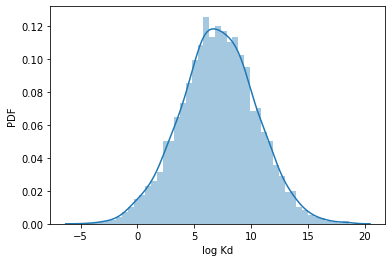

In [27]:
print('Degree 0 nodes: ', K_from_copula_list.count(0))

sns.distplot(np.log(Kd_from_copula_list))
plt.xlabel('log Kd')
plt.ylabel('PDF')

## Checks on original Kd duistribution and Kd from copula

print(np.mean(np.log(Kd_from_copula_list)))
print(mean_log_Kd)
print(np.std(np.log(Kd_from_copula_list)))
print(std_log_Kd)

## Correlation between k and Kd obtained from copulaprint(std_log_Kd)

stats.spearmanr(K_from_copula_list,Kd_from_copula_list)

print(sum(K_from_copula_list) % 2 == 0) ## True if graphical

## Making the degree sequence graphical

if (sum(K_from_copula_list) % 2 == 0) is False:
    non_1_degrees = []
    for x in K_from_copula_list:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_list.index(random_non_1_entry)
    K_from_copula_list[j] = K_from_copula_list[j] - 1
    print(sum(K_from_copula_list) % 2 == 0)
else:
    print(sum(K_from_copula_list) % 2 == 0) 
    
different_target_annotations_copula = list(set(K_from_copula_list))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(Kd_from_copula_list[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

## Validating the data generated from Copula

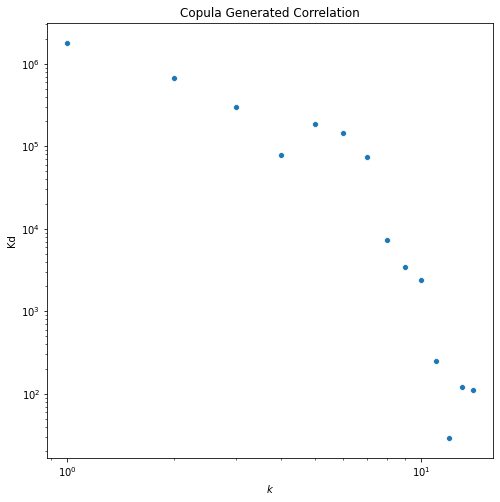

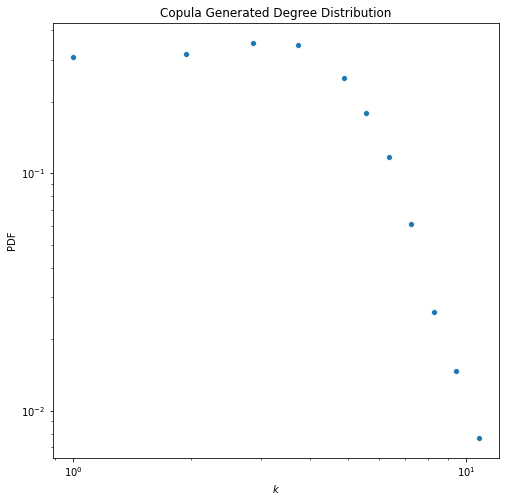

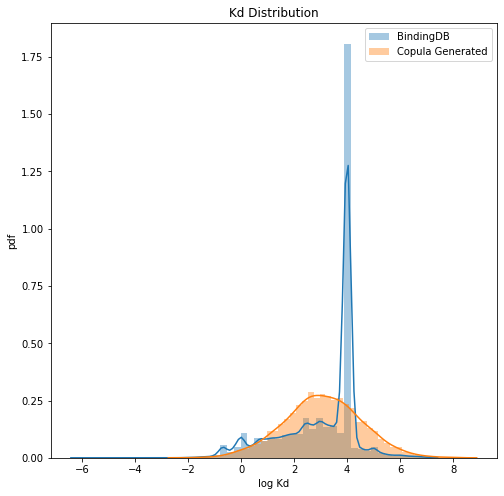

In [28]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(K_from_copula_list,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(Kd_from_copula_list), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

## Generating Network

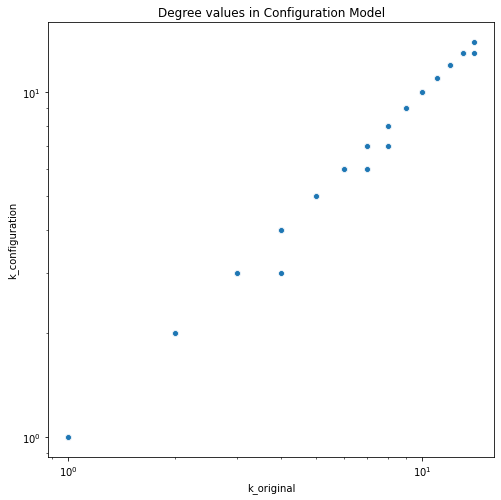

Correlation between k and Kd:  SpearmanrResult(correlation=-0.44602382679857777, pvalue=4.6289664862588026e-243)
Max degree in degree sequence:  14
Max degree in network:  14
Mean degree in degree sequence:  4.942
Mean degree in network:  4.9404


[None,
 Text(0, 0.5, 'PDF'),
 None,
 Text(0.5, 0, '$k$'),
 Text(0.5, 1.0, 'Degree distribution')]

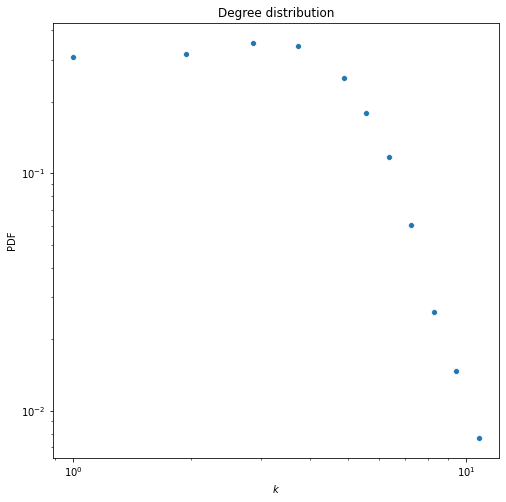

In [29]:
node_Kd_values = dict(zip(range(len(K_from_copula_list)), Kd_from_copula_list)) ## Nodes are numbered 0, 1,..., N
G = nx.configuration_model(K_from_copula_list, create_using=nx.Graph(), seed=None)

## Checks after removing self-loops and multi-edges

degrees_from_network = [G.degree(node) for node in list(G.nodes())]
figure(figsize=(8, 8))
ax = sns.scatterplot(K_from_copula_list, degrees_from_network)
ax.set(title='Degree values in Configuration Model',xscale='log',yscale='log',xlabel='k_original',ylabel='k_configuration')
plt.show()

print('Correlation between k and Kd: ', stats.spearmanr(degrees_from_network, Kd_from_copula_list))

print('Max degree in degree sequence: ', max(K_from_copula_list))
print('Max degree in network: ', max(degrees_from_network))

print('Mean degree in degree sequence: ', np.mean(K_from_copula_list))
print('Mean degree in network: ', np.mean(degrees_from_network))

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_network,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Degree distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

In [30]:
## Checks for the Poisson degree distribution

print('Mean: ', np.mean(degrees_from_network))
print('Variance: ', np.std(degrees_from_network)**2)

Mean:  4.9404
Variance:  4.90364784


100%|██████████| 12351/12351 [00:00<00:00, 667093.96it/s]


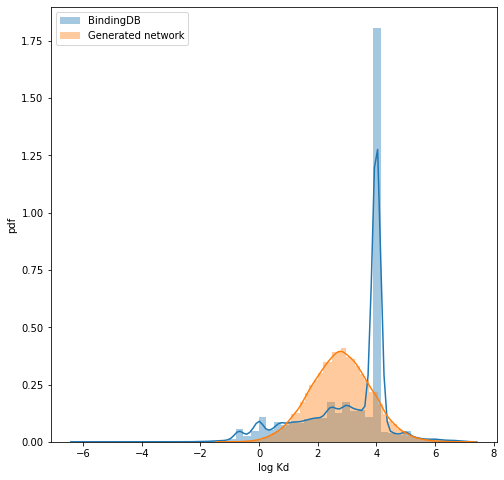

Threshold:  604.0962026432809


In [31]:
network_data = generate_network(G, node_Kd_values, kd_list, p_bind = 0.5)

100%|██████████| 4868/4868 [00:10<00:00, 457.27it/s]


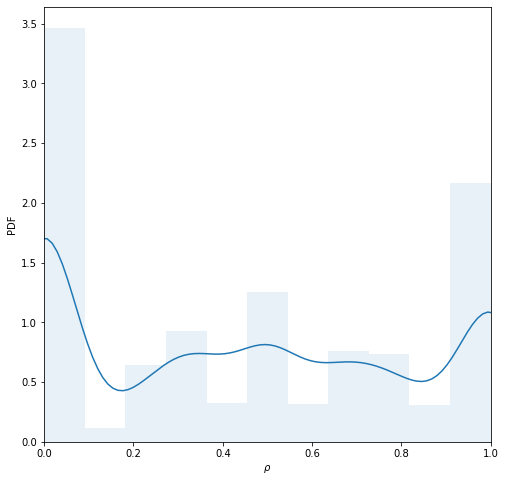

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.4999595174479799


 61%|██████    | 6059/10000 [1:45:28<1:08:36,  1.04s/it]


Loops  6060
Error margin:  [9.99132499e-06]


3706it [00:09, 401.82it/s]


AUC:  0.7828104202652271
AUP:  0.7430792479877962
Transductive performance:
AUC:  0.788718490180905
AUP:  0.7606139676089974


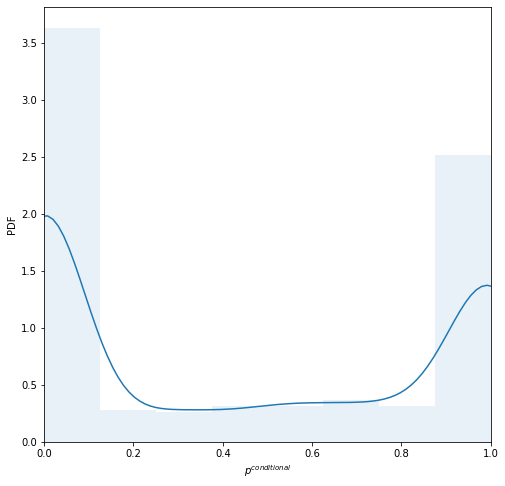

In [32]:
run_configuration_model(network_data)

# Poisson + No Correlation

## Shuffle Kd

In [33]:
correlated_labels = network_data['edge_Kd'] 
shuffle(correlated_labels)
network_data['edge_Kd'] = correlated_labels

/miniconda/lib/python3.6/random.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]


In [34]:
p_bind = 0.5
Kd_for_edges = network_data['edge_Kd'].tolist()
threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
print('Threshold: ', threshold) ## in nM

binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

network_data['binary_label'] = binary_labels

Threshold:  604.0962026432809


100%|██████████| 4880/4880 [00:10<00:00, 449.82it/s]


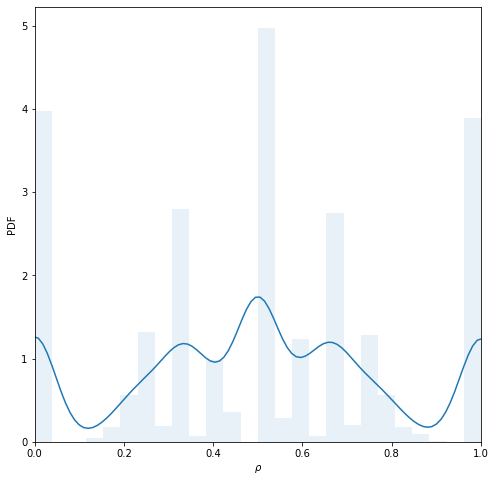

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.4999595174479799


 72%|███████▏  | 7234/10000 [2:04:56<47:46,  1.04s/it]  


Loops  7235
Error margin:  [9.99491891e-06]


3706it [00:08, 438.33it/s]


AUC:  0.4950454232636191
AUP:  0.49589063187987575
Transductive performance:
AUC:  0.4959365552022519
AUP:  0.49638015522197343


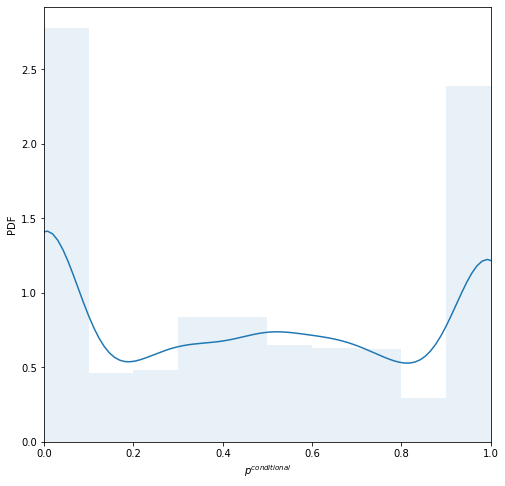

In [35]:
run_configuration_model(network_data)

## Check: k and Kd correlation after shuffling

100%|██████████| 14/14 [00:00<00:00, 1658.34it/s]


Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=0.20283439893688418, pvalue=1.4047432143119732e-47)
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.5032967032967033, pvalue=0.06656042759911303)


[None,
 Text(0, 0.5, 'Kd'),
 None,
 Text(0.5, 0, '$k$'),
 Text(0.5, 1.0, 'Shuffled Kd')]

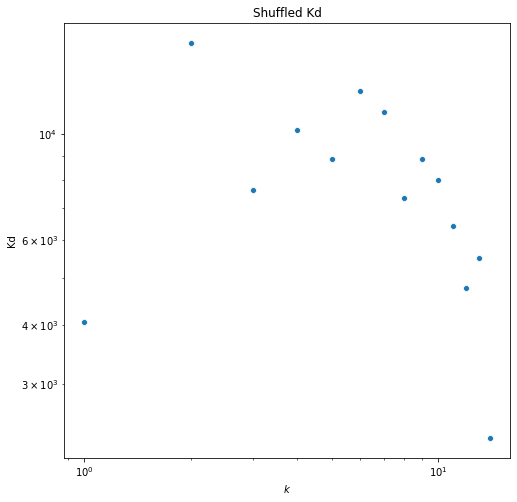

In [36]:
all_degree_list = []
all_avg_Kd_list = []

for node in tqdm(range(simulated_network_nodes)):
    sub_df = network_data[(network_data['node_1']==node) | (network_data['node_2']==node)]
    all_degree_list.append(len(sub_df))
    all_avg_Kd_list.append(np.mean(sub_df['edge_Kd'].tolist()))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(all_degree_list,all_avg_Kd_list))

different_target_annotations_copula = list(set(all_degree_list))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(all_degree_list,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(all_avg_Kd_list[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Shuffled Kd',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')